<a href="https://colab.research.google.com/github/kaung-htet-myat/Multi-teachers-Knowledge-Distillation/blob/master/Hydra_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Models to train:
1. resnet20
2. resnet14
3. resnet32
4. resnet44

In [ ]:
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

Tesla P100-PCIE-16GB


In [ ]:
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import scipy as sp
from scipy.stats import entropy
from tensorflow.keras.utils import plot_model

from nets.keras_resnet import resnet_v1, resnet_v2
from nets.student_model_multeacherKD import resnet_student
from nets.student_model_multeacherKD_wo_GT import resnet_student_wo_GT

In [ ]:
seed = 6
batch_size = 32
temperature = 4
alpha = 0.5

In [ ]:
# js_divergence

def JS_Divergence(softmaxes):
  softsum = np.zeros(softmaxes[0].shape)
  jsd = 0.0

  for i in softmaxes:
    j = np.asarray(i) 
    j = j/j.sum()
    softsum += j

  m = 1./3*softsum 

  for i in softmaxes:
    j = np.asarray(i)
    jsd += sp.stats.entropy(j,m, base=np.e)/5.

  return jsd

In [ ]:
def kd_loss(y_true, y_pred):

  '''
    Calculate modified Kullback-Leibler Divergence between ground truths and prediction.
  '''

  y_true_normal = y_true[:,:10]
  y_true_soft = y_true[:,10:]
  y_pred_normal = y_pred[:,:10]
  y_pred_soft = y_pred[:, 10:]

  t = temperature

  #a = tf.keras.losses.kullback_leibler_divergence(y_true_soft, y_pred_soft) # kl divergence between softened logits of teacher and student
  a = tf.keras.losses.categorical_crossentropy(y_true_soft, y_pred_soft)
  b = tf.keras.losses.categorical_crossentropy(y_true_normal, y_pred_normal) # cross entropy between student's prediction and ground truth label

  return a*(alpha*t*t)+b*(1-alpha)


In [ ]:
def js_loss(y_true, y_pred):

  '''
    Calculate jensen_shennon_divergence between ground truths and prediction.
  '''

  return nsl.lib.jensen_shannon_divergence(np.array(y_true), tf.keras.utils.to_categorical(np.argmax(np.array(y_pred), axis=1)), axis=1) # js divergence between logits of teacher and student

In [ ]:
def kd_evaluate(y_true, y_pred):
    y_pred_normal = y_pred[:,:10]
    
    #return tf.keras.metrics.categorical_accuracy(y_true, y_pred_normal)
    
    m = tf.keras.metrics.CategoricalAccuracy()
    #_ = m.update_state(y_true, y_pred_normal) 

    m(y_true, y_pred_normal)
  
    acc = m.result().numpy() 
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss = cce(y_true, y_pred_normal).numpy()
    
    return (loss,acc)

In [ ]:
def multihead_kd_evaluate(y_true, y_pred):

    #y_pred_normal = y_pred[:,:,:10] # (4,1000,10)
    
    #return tf.keras.metrics.categorical_accuracy(y_true, y_pred_normal)

    pred = []
    acc = []
    loss = []
    
    m = tf.keras.metrics.CategoricalAccuracy()
    cce = tf.keras.losses.CategoricalCrossentropy()
    #_ = m.update_state(y_true, y_pred_normal) 

    for i in range(len(y_pred)): # 4
      m(y_true, y_pred[i][:,:10])
      pred.append(y_pred[i][:,:10])
      acc.append(m.result().numpy()) 
      loss.append(cce(y_true, y_pred[i][:,:10]).numpy())
      m.reset_states

    pred = np.array(pred)
    avg_pred = pred.mean(axis=0)
    m(y_true, avg_pred)
    avg_acc = m.result().numpy()
    m.reset_states
    
    return (loss,acc, avg_acc)

In [ ]:
def new_softmax(logits, temperature=1):

  '''
    Annealing the temperature of the softmax.
  '''
  logits = logits/temperature
  return np.exp(logits)/np.sum(np.exp(logits))

## Data Loading

In [ ]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()
train_data, test_data = train_data.astype('float32')/255. , test_data.astype('float32')/255.
train_labels, test_labels = train_labels.astype('int32'), test_labels.astype('int32')

x_train_mean = np.mean(train_data, axis=0)
train_data -= x_train_mean
test_data -= x_train_mean

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

def random_shift(image):
    return  tf.keras.preprocessing.image.random_shift(image, 0.1, 0.1,  row_axis=0, col_axis=1, channel_axis=2)

def augment(image, label):
    image = tf.numpy_function(random_shift, [image], tf.float32)
    image = tf.image.random_flip_left_right(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_ds = train_ds.shuffle(10000, seed=seed)
train_ds = train_ds.map(augment)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
train_steps_per_epoch = tf.data.experimental.cardinality(train_ds)

test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

print(train_data.shape)
print(train_labels.shape)
print(test_labels.shape)

170500096/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 10)
(10000, 10)


## Teacher Models Loading

In [ ]:
resnet_20 = tf.keras.models.load_model('models/resnet_20')
resnet_20.evaluate(test_data, test_labels)

pred = resnet_20(test_data)
m = tf.keras.metrics.CategoricalAccuracy()
m(test_labels, pred)
print("Accuracy: ",m.result().numpy())

313/313 [==============================] - 1s 4ms/step - loss: 0.5051 - accuracy: 0.8766
Accuracy:  0.8766


In [ ]:
resnet_14 = tf.keras.models.load_model('models/resnet_14')
resnet_14.evaluate(test_data, test_labels)

pred = resnet_14(test_data)
m = tf.keras.metrics.CategoricalAccuracy()
m(test_labels, pred)
print("Accuracy: ",m.result().numpy())

Accuracy:  0.8612


In [ ]:
resnet_32 = tf.keras.models.load_model('models/resnet_32')
resnet_32.evaluate(test_data, test_labels)

pred = resnet_32(test_data)
m = tf.keras.metrics.CategoricalAccuracy()
m(test_labels, pred)
print("Accuracy: ",m.result().numpy())

313/313 [==============================] - 2s 6ms/step - loss: 0.5683 - accuracy: 0.8672
Accuracy:  0.8672


In [ ]:
resnet_44 = tf.keras.models.load_model('models/resnet_44')
resnet_44.evaluate(test_data, test_labels)

pred = resnet_44(test_data)
m = tf.keras.metrics.CategoricalAccuracy()
m(test_labels, pred)
print("Accuracy: ",m.result().numpy())

313/313 [==============================] - 2s 7ms/step - loss: 0.5796 - accuracy: 0.8735
Accuracy:  0.8735


## Teachers' logits extractions

In [ ]:
def new_labels(model, data, label, t, g_truth=False):
  model_sans_softmax = keras.models.Model(inputs=model.input, outputs = model.get_layer('logits').output)
  new_logits = model_sans_softmax.predict(data)
  unsoftened_prob = new_softmax(new_logits, 1)
  softened_prob = new_softmax(new_logits, t)
  if g_truth:
    labels = np.hstack([label, softened_prob])
  else:
    labels = softened_prob

  return labels

In [ ]:
# ,g_truth=True
rn20_train_labels = new_labels(resnet_20, train_data, train_labels, t=temperature)
rn20_test_labels = new_labels(resnet_20, test_data, test_labels, t=temperature)
print(rn20_train_labels.shape)
print(rn20_test_labels.shape)

(50000, 10)
(10000, 10)


In [ ]:
rn14_train_labels = new_labels(resnet_14, train_data, train_labels, t=temperature)
rn14_test_labels = new_labels(resnet_14, test_data, test_labels, t=temperature)
print(rn14_train_labels.shape)
print(rn14_test_labels.shape)

(50000, 10)
(10000, 10)


In [ ]:
rn32_train_labels = new_labels(resnet_32, train_data, train_labels, t=temperature)
rn32_test_labels = new_labels(resnet_32, test_data, test_labels, t=temperature)
print(rn32_train_labels.shape)
print(rn32_test_labels.shape)

(50000, 10)
(10000, 10)


In [ ]:
rn44_train_labels = new_labels(resnet_44, train_data, train_labels, t=temperature)
rn44_test_labels = new_labels(resnet_44, test_data, test_labels, t=temperature)
print(rn44_train_labels.shape)
print(rn44_test_labels.shape)

(50000, 10)
(10000, 10)


## Student Data Augmentation (with tf.data)

In [ ]:
student_train_ds = tf.data.Dataset.from_tensor_slices((train_data, {'soft_prob_1':rn14_train_labels,'soft_prob_2':rn20_train_labels,'soft_prob_3':rn32_train_labels,'soft_prob_4':rn44_train_labels}))
student_train_ds = student_train_ds.shuffle(10000, seed=seed)
student_train_ds = student_train_ds.map(augment)
student_train_ds = student_train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
train_steps_per_epoch = tf.data.experimental.cardinality(student_train_ds)

student_test_ds = tf.data.Dataset.from_tensor_slices((test_data, {'soft_prob_1':test_labels,'soft_prob_2':test_labels,'soft_prob_3':test_labels,'soft_prob_4':test_labels}))
student_test_ds = student_test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# hinton datsets

hinton_train_labels = [rn14_train_labels, rn20_train_labels, rn32_train_labels, rn44_train_labels]
hinton_train_labels = np.array(hinton_train_labels)
hinton_train_labels = hinton_train_labels.mean(axis=0)
print(hinton_train_labels.shape)

hinton_train_ds = tf.data.Dataset.from_tensor_slices((train_data, hinton_train_labels))
hinton_train_ds = hinton_train_ds.shuffle(10000, seed=seed)
hinton_train_ds = hinton_train_ds.map(augment)
hinton_train_ds = hinton_train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

hinton_test_labels = [rn14_test_labels, rn20_test_labels, rn32_test_labels, rn44_test_labels]
hinton_test_labels = np.array(hinton_test_labels)
hinton_test_labels = hinton_test_labels.mean(axis=0)

hinton_test_ds = tf.data.Dataset.from_tensor_slices((test_data, hinton_test_labels))
hinton_test_ds = hinton_test_ds.shuffle(10000, seed=seed)
hinton_test_ds = hinton_test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


## Defining Hydra and Hinton Models

In [ ]:
depth = 20

In [ ]:
hydra = resnet_student_wo_GT((32,32,3), temperature=temperature, body_depth=depth, num_blocks_head=1, num_classes=10)
hydra.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 16)   64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 32, 32, 16)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [ ]:
hinton_head = resnet_student((32,32,3), temperature=temperature, body_depth=depth, num_head=1, num_blocks_head=1, num_classes=10)
hinton_head.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32, 32, 16)   64          conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_38[0][0]     
___________________________________________________________________________________________

## Hinton Head Training

In [ ]:
filepath = ('models/hinton_cp/cp.ckpt')

hinton_cp = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_hinton = TimingCallback()

In [ ]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch>=25:
    lr*= 1e-1
  elif epoch>=50:
    lr*= 1e-2
  elif epoch>=100:
    lr*= 1e-3
  return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule(0), momentum=0.9)

In [ ]:
hinton_head.compile(optimizer=sgd, loss=kd_loss, metrics=['accuracy'])

In [ ]:
hinton_hist = hinton_head.fit(hinton_train_ds, epochs=150, validation_data=(hinton_test_ds), callbacks=[hinton_cp, time_hinton, lr_scheduler])

Epoch 1/150
1563/1563 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.2646
Epoch 00001: saving model to /content/drive/My Drive/MulTeacher Models/students/hinton_20_75_cp/cp.ckpt
1563/1563 [==============================] - 39s 25ms/step - loss: 0.6661 - accuracy: 0.2646 - val_loss: 0.6449 - val_accuracy: 0.3352 - lr: 0.0010
Epoch 2/150
1561/1563 [============================>.] - ETA: 0s - loss: 0.5967 - accuracy: 0.3633
Epoch 00002: saving model to /content/drive/My Drive/MulTeacher Models/students/hinton_20_75_cp/cp.ckpt
1563/1563 [==============================] - 38s 24ms/step - loss: 0.5967 - accuracy: 0.3634 - val_loss: 0.6010 - val_accuracy: 0.4024 - lr: 0.0010
Epoch 3/150
1563/1563 [==============================] - ETA: 0s - loss: 0.5674 - accuracy: 0.4088
Epoch 00003: saving model to /content/drive/My Drive/MulTeacher Models/students/hinton_20_75_cp/cp.ckpt
1563/1563 [==============================] - 38s 24ms/step - loss: 0.5674 - accuracy: 0.4088 - 

In [ ]:
print(np.sum(time_hinton.logs))

5801.244107889999


In [ ]:
pred = hinton_head(test_data)
(loss, acc) = kd_evaluate(test_labels, pred)
print(acc)

0.7187


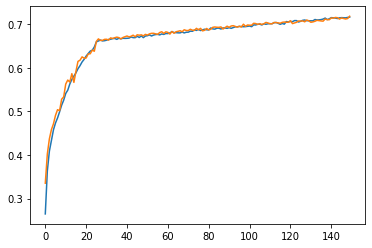

In [ ]:
plt.figure()
plt.plot(hinton_hist.history['accuracy'], label='Train Accuracy')
plt.plot(hinton_hist.history['val_accuracy'], label='Validation Accuracy')
plt.show()

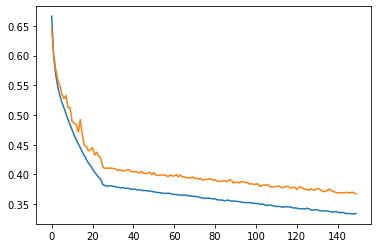

In [ ]:
plt.figure()
plt.plot(hinton_hist.history['loss'], label='Train Loss')
plt.plot(hinton_hist.history['val_loss'], label='Validation Loss')
plt.show()

## Hydra Weights Initialization

In [ ]:
hinton_head_1 = tf.keras.models.Model(inputs= hinton_head.input, outputs= hinton_head.get_layer('soft_prob_1').output)


body = 4+(3*int((depth-2)/6)-1-2)*7+(2*8)
print(body)
#head = body+11 #for training with ground truth
#head = body+12 #for training without ground truth
#head = body+19 #for training without ground truth 2 res-blocks per head

for i in range(body):
  hydra.layers[i].set_weights(hinton_head_1.layers[i].get_weights())
  hydra.layers[i].trainable = False

count = body
for i in hinton_head_1.layers[body:]:
  weights = i.get_weights()
  for _ in range(4):
    if count<len(hydra.layers):
      hydra.layers[count].set_weights(weights)
      count+=1


for i in hydra.layers:
  print(i, i.trainable)


#hinton_softmax = hinton_head.layers[head].get_weights()
#hinton_softprob = hinton_head.layers[head+1].get_weights()
#hinton_concatenate = hinton_head.layers[head+2].get_weights()

#hydra.layers[85].set_weights(hinton_softmax)
#hydra.layers[86].set_weights(hinton_softprob)
#hydra.layers[87].set_weights(hinton_softmax)
#hydra.layers[88].set_weights(hinton_softprob)
#hydra.layers[89].set_weights(hinton_softmax)
#hydra.layers[90].set_weights(hinton_softprob)
#hydra.layers[91].set_weights(hinton_softmax)
#hydra.layers[92].set_weights(hinton_softprob)
#hydra.layers[93].set_weights(hinton_concatenate)
#hydra.layers[94].set_weights(hinton_concatenate)
#hydra.layers[95].set_weights(hinton_concatenate)
#hydra.layers[96].set_weights(hinton_concatenate)



In [ ]:
filepath = ('model/hydra_cp/cp.ckpt')

hydra_cp = keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
def lr_schedule(epoch):
  lr = 1e-3
  if epoch>=50:
    lr*= 1e-1
  elif epoch>=100:
    lr*= 1e-2
  elif epoch>=150:
    lr*= 1e-3
  return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

time_hydra = TimingCallback()

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule(0), momentum=0.9)

In [ ]:
hydra.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 32, 32, 16)   64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 32, 32, 16)   0           batch_normalization_13[0][0]     
____________________________________________________________________________________________

In [ ]:
kl_loss = tf.keras.losses.KLDivergence()
ce_loss = tf.keras.losses.CategoricalCrossentropy()
cos_loss = tf.keras.losses.CosineSimilarity()

hydra.compile(optimizer=sgd, loss= [ce_loss, ce_loss, ce_loss, ce_loss] , metrics=['accuracy'])

In [ ]:
hydra_hist = hydra.fit(student_train_ds, epochs=200, validation_data=(student_test_ds), callbacks=[hydra_cp, lr_scheduler])